In [2]:
import os
import numpy as np
import cloud_net_model
os.environ["CUDA_VISIBLE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
from skimage.transform import resize
from skimage import img_as_uint
from tensorflow.python.client import device_lib
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral, create_pairwise_gaussian
weights_path = '/home/wxw/.local/share/cloud-net/Cloud-Net/38-Cloud dataset/Cloud-Net_trained_on_38-Cloud_training_patches.h5'
model = cloud_net_model.model_arch(input_rows=384,
                                       input_cols=384,
                                       num_of_channels=4,
                                       num_of_classes=1)
model.load_weights(weights_path)
from skimage.io import imread,imsave,imshow
import numpy as np
import torch as nn

In [3]:
def split_and_resize_img(image,w,h):
    image=image/65536
    LU=image[0:512,0:512]
    RU=image[512:1024,0:512]
    LD=image[0:512,512:1024]
    RD=image[512:1024,512:1024]
    LU = resize (LU, (w, h), preserve_range=True, mode='symmetric')
    RU = resize (RU, (w, h), preserve_range=True, mode='symmetric')
    LD = resize (LD, (w, h), preserve_range=True, mode='symmetric')
    RD = resize (RD, (w, h), preserve_range=True, mode='symmetric')
    return LU,RU,LD,RD

def thres_adjust(pred,threshold):
    pred[pred>=threshold]=1
    pred[pred<threshold]=0
    pred=pred.astype(np.float32)
    return pred

In [29]:
img=imread('/home/wxw/.local/share/cloud-net/datas/area2-0.tiff')
img = resize (img, (384, 384), preserve_range=True, mode='symmetric')
img=np.array([img])
pred=model.predict(img)
# pred=thres_adjust(pred,0.00000000047)
pred=pred[0]
pred[pred<1e-8]=1e-8
rgb=img[0][:,:,0:3]
rgb=rgb.astype(np.uint8)

In [5]:
np.min(1-pred)

0.0

In [6]:
pred=pred.reshape(384,384)

In [19]:
d = dcrf.DenseCRF2D(384, 384, 2)
U = np.expand_dims(-np.log(pred), axis=0)
temp=1-pred
temp[temp<1e-8]=1e-8
U_ = np.expand_dims(-np.log(temp), axis=0)
unary = np.concatenate((U_, U), axis=0)
unary = unary.reshape((2, -1))
unary.shape
# U=unary_from_softmax(pred,scale=None,clip=1e-5)
d.setUnaryEnergy(unary)
d.addPairwiseGaussian(sxy=(3,3), compat=3)
d.addPairwiseBilateral(sxy=(10,10), srgb=(13,13,13), rgbim=rgb, compat=10)
Q = d.inference(5)
Map = np.argmax(Q, axis=0).reshape((384,384))

/home/wxw/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


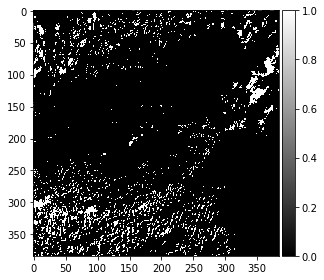

In [20]:
imshow(Map,cmap='gray')

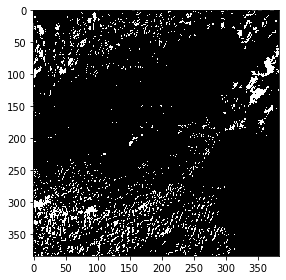

In [31]:
pred=thres_adjust(pred,0.00000047)
imshow(pred)

In [30]:
np.min(pred)

1e-08

In [34]:
0.71*0.13/0.2597

0.35541008856372736

In [35]:
1-0.6238-0.3556

0.02059999999999995